In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors



In [2]:
plt.rc('font',size=20)
pd.set_option('max_column',200)

In [3]:
m=pd.read_csv('../Downloads/catalog/m_both_all_i<24.2_ira_c_err_epoch.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,13,15,18,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
md=pd.read_csv('../Downloads/catalog/m_both_stars_i<24.2_ira_c_dist_sm.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
ms=m[(m.i_extendedness_value==0)&(m.type==6)]
msg=m[(m.i_extendedness_value==1)&(m.type==6)]
mg=m[(m.i_extendedness_value==1)&(m.type==3)]
mgs=m[(m.i_extendedness_value==0)&(m.type==3)]

In [54]:
mdd=pd.merge(md,m,how='inner',on=['# object_id'])

In [6]:
m.columns

Index(['Unnamed: 0', '# object_id', 'i_extendedness_value', 'ra_1', 'dec_1',
       'r_extendedness_value', 'i_sdsscentroid_ra', 'i_sdsscentroid_dec',
       'i_sdsscentroid_rasigma', 'i_sdsscentroid_decsigma', 'g_cmodel_mag',
       'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'g_psfflux_mag', 'r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag',
       'g_psfflux_magsigma', 'r_psfflux_magsigma', 'i_psfflux_magsigma',
       'z_psfflux_magsigma', 'a_g', 'a_r', 'a_i', 'a_z', 'col1', 'ra_2',
       'dec_2', 'flags', 'type', 'rowc_r', 'colc_r', 'rowcErr_r', 'colcErr_r',
       'u', 'g', 'r', 'i', 'z', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z',
       'psfmag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i',
       'psfmagerr_z', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z', 'Separa

In [32]:
md.columns

Index(['Unnamed: 0', '# object_id', 'ra_1', 'dec_1', 'r_extendedness_value',
       'i_sdsscentroid_ra', 'i_sdsscentroid_dec', 'i_sdsscentroid_rasigma',
       'i_sdsscentroid_decsigma', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'g_psfflux_mag', 'r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag',
       'g_psfflux_magsigma', 'r_psfflux_magsigma', 'i_psfflux_magsigma',
       'z_psfflux_magsigma', 'a_g', 'a_r', 'a_i', 'a_z', 'col1', 'ra_2',
       'dec_2', 'flags', 'type', 'rowc_r', 'colc_r', 'rowcErr_r', 'colcErr_r',
       'u', 'g', 'r', 'i', 'z', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z',
       'psfmag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i',
       'psfmagerr_z', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z', 'Separation', 'ug', 'gr', 'gi',

In [8]:
#clip with 3sigma with cov matrix
def calc_cov(mc):
    if mc.shape[0]==2 and mc.shape[1]!=2:
        mc=mc.T
    cov=np.cov(mc.T)
    return cov

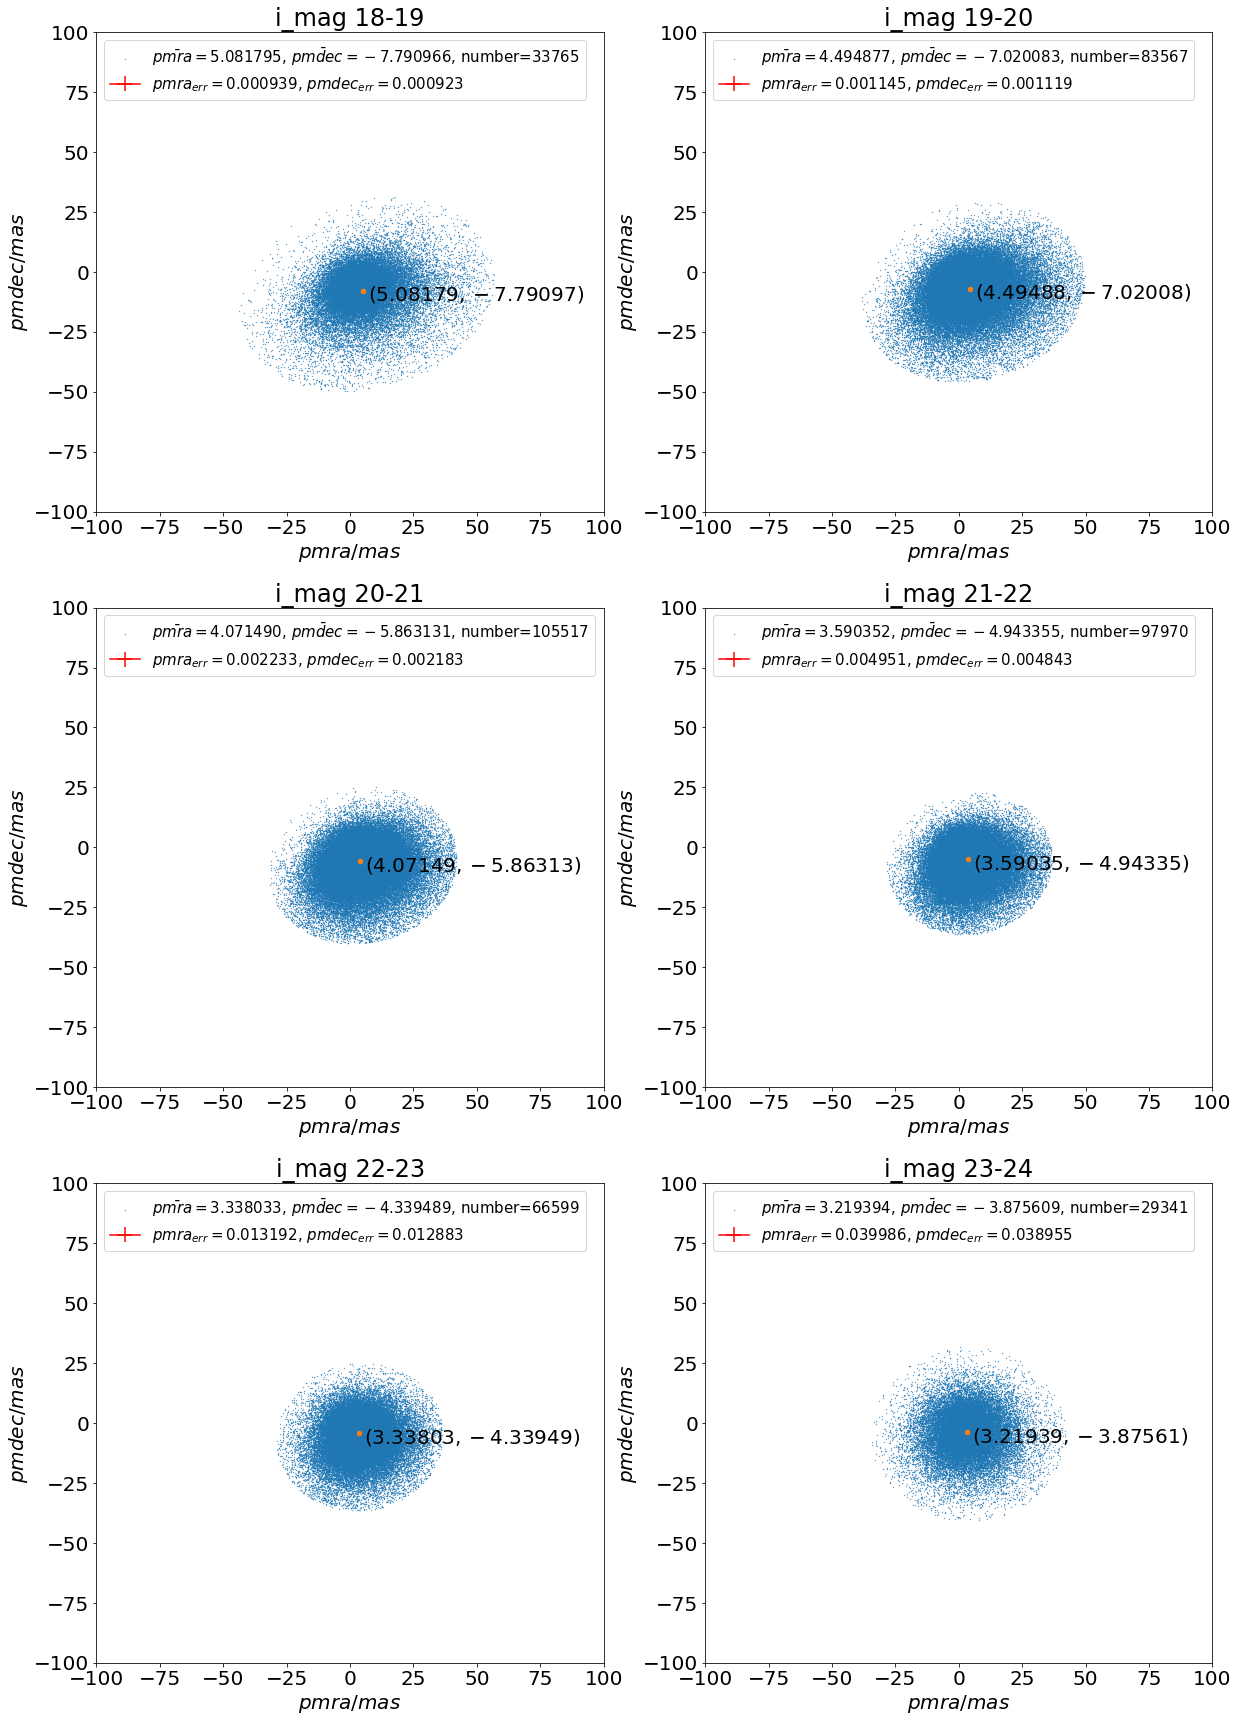

In [9]:
ss=ms
t2=[[]*i for i in range(6)]
mm2=[[]*i for i in range(6)]
l2=[[]*i for i in range(6)]
for i in range(6):
    t2[i]=ss[(ss.i_psfflux_mag>=18+i)&(ss.i_psfflux_mag<19+i)]
mram2=[]
mdecm2=[]
mrae2=[]
mdece2=[]
for i in range(6):
    mx2=np.array([t2[i].pmra,t2[i].pmdec])
    mx2=mx2.T
    for j,x in enumerate(mx2):
        cov=calc_cov(mx2)
        if (x-mx2.mean(0)).dot(np.linalg.inv(cov)).dot(x-mx2.mean(0))<11.8:
            l2[i].append(j)
    mm2[i]=t2[i].iloc[l2[i]]
    mram2.append(np.average(mm2[i].pmra,weights=1/mm2[i].pmra_err**2))
    mdecm2.append(np.average(mm2[i].pmdec,weights=1/mm2[i].pmdec_err**2))
    mrae2.append(np.sqrt(1/np.sum(1/mm2[i].pmra_err**2)))
    mdece2.append(np.sqrt(1/np.sum(1/mm2[i].pmdec_err**2)))
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(321+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(mm2[i].pmra,mm2[i].pmdec,alpha=1,s=0.1,label=r'$\bar{pmra}=%f$, $\bar{pmdec}=%f$, number=%.0f'%(mram2[i],mdecm2[i],len(mm2[i])))
    plt.scatter(mram2[i],mdecm2[i],s=20)
    plt.errorbar(mram2[i],mdecm2[i],xerr=mrae2[i],yerr=mdece2[i],color='red',label=r'$pmra_{err}=%f$, $pmdec_{err}=%f$'%(mrae2[i],mdece2[i]))
    plt.text(mram2[i]+2,mdecm2[i]-4,'$(%0.5f,%0.5f)$'%(mram2[i],mdecm2[i]))
    plt.ylabel(r'$pmdec/mas$')
    plt.xlabel(r'$pmra/mas$')
    plt.legend(loc=2,fontsize=15)
    plt.axis([-100,100,-100,100])    

Text(0, 0.5, 'proper motion/mas*yr^-1')

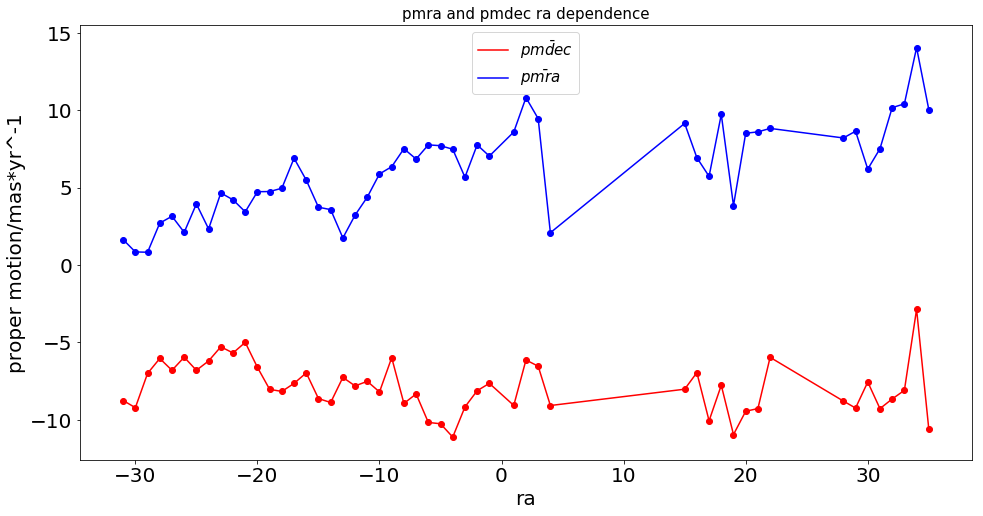

In [22]:
xm=[]
ram=[]
decm=[]
for i in range(360):
    j=i+180
    if j>360:
        j=j-360
    t=ms[(ms.i_sdsscentroid_ra>j)&(ms.i_sdsscentroid_ra<=(j+1))]
    if t.empty:
        continue
    if j>180:
        xm.append(j-360)
    else:
        xm.append(j)
    ram.append(np.average(t.pmra,weights=1/t.pmra_err**2))
    decm.append(np.average(t.pmdec,weights=1/t.pmdec_err**2))
plt.figure(figsize=(16,8))
plt.plot(xm,decm,color='red',label=r'$\bar{pmdec}$')
plt.plot(xm,ram,color='blue',label=r'$\bar{pmra}$')
plt.scatter(xm,decm,color='red')
plt.scatter(xm,ram,color='blue')
plt.legend(loc=9,fontsize=15)
plt.title(r'pmra and pmdec ra dependence',fontsize=15)
plt.xlabel('ra')
plt.ylabel('proper motion/mas*yr^-1')

Text(0.5, 1.0, 'position separation between HSC and S82 histogram')

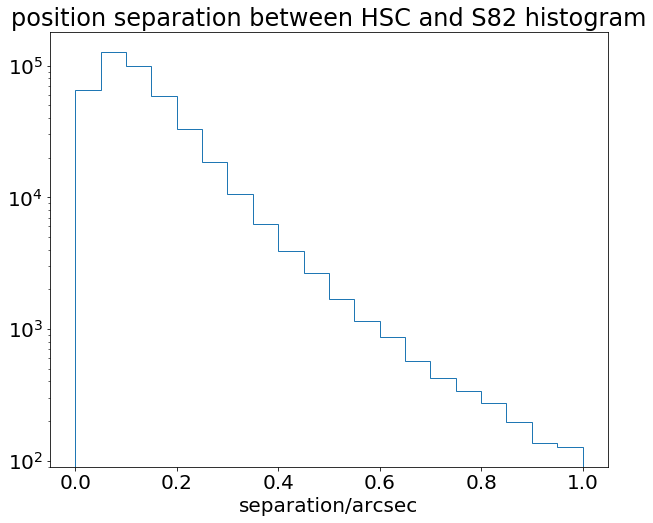

In [30]:
plt.figure(figsize=(10,8))
plt.hist(ms.Separation,bins=20,histtype='step')
plt.yscale('log')
plt.xlabel('separation/arcsec')
plt.title('position separation between HSC and S82 histogram')

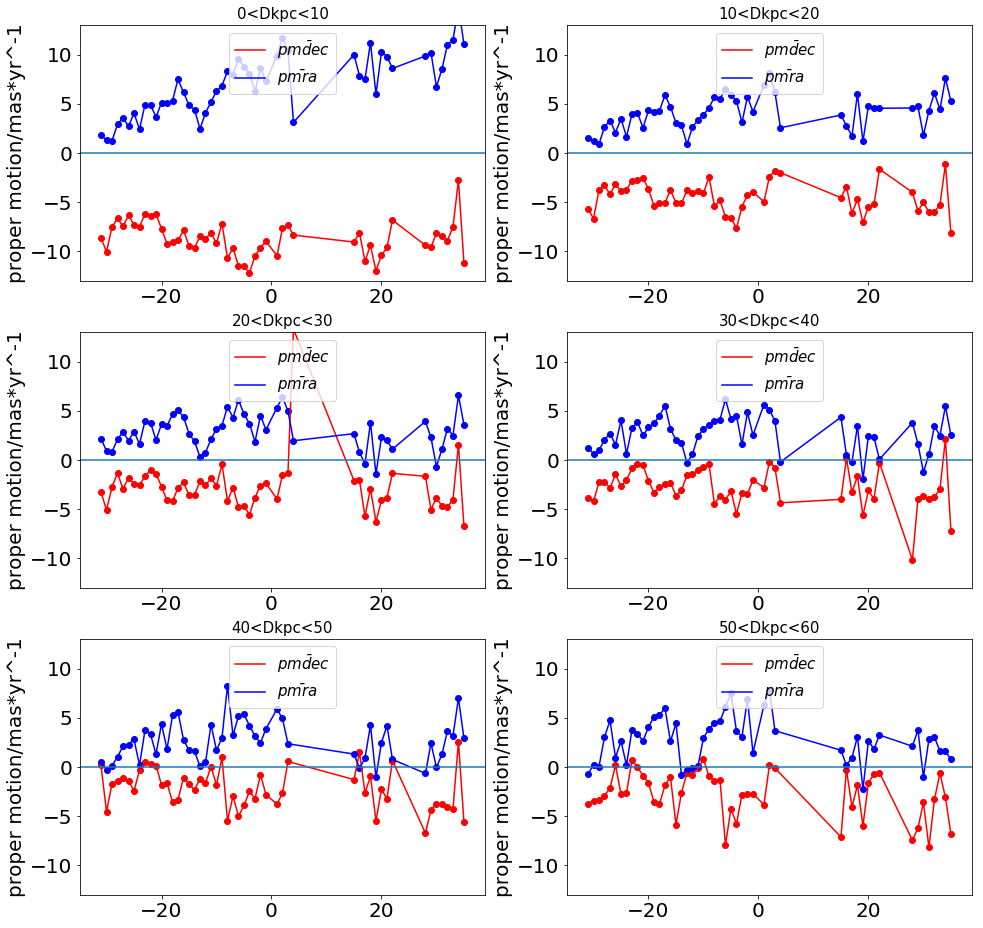

In [45]:
plt.figure(figsize=(16,16))
for k in range(6):
    xm=[]
    ram=[]
    decm=[]
    mdd=md[(md.Dkpc>k*10)&(md.Dkpc<(k+1)*10)]
    for i in range(360):
        j=i+180
        if j>360:
            j=j-360
        t=mdd[(mdd.i_sdsscentroid_ra>j)&(mdd.i_sdsscentroid_ra<=(j+1))]
        if t.empty:
            continue
        if j>180:
            xm.append(j-360)
        else:
            xm.append(j)
        ram.append(np.average(t.pmra))
        decm.append(np.average(t.pmdec))
    plt.subplot(3,2,k+1)
    plt.plot(xm,decm,color='red',label=r'$\bar{pmdec}$')
    plt.plot(xm,ram,color='blue',label=r'$\bar{pmra}$')
    plt.scatter(xm,decm,color='red')
    plt.scatter(xm,ram,color='blue')
    plt.legend(loc=9,fontsize=15)
    plt.axhline(0)
    plt.ylim(-13,13)
    plt.title(str(k*10)+r'<Dkpc<'+str((k+1)*10),fontsize=15)
    plt.ylabel('proper motion/mas*yr^-1')